In [65]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import seaborn as sns
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import scipy
from scipy import stats

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.Chem import Draw

In [2]:
# The same color scheme for all plots
cmap_c = sns.color_palette("mako_r", as_cmap=True)
cmap_d = sns.color_palette("muted")

# Compare docking results: 7NIO vs 7NN0

Compare results after refinement docking

In [3]:
path_7nio = ("7NIO_pocket1/refinement_docking_23-01-28_12-46/"
             "7NIO_pocket1_docking_results_merged_filtered_-11_23-01-28_12-46.csv")
path_7nn0 = "7NN0_pocket1/7nn0_pocket1_final_results.csv"
df_7nio = pd.read_csv(path_7nio)
df_7nn0 = pd.read_csv(path_7nn0)

Transform the Molecule columns to string

In [4]:
df_7nn0.Molecule = df_7nn0.Molecule.astype('string')
df_7nio.Molecule = df_7nio.Molecule.astype('string')

In results for 7NN0 there is an 'os' at the end of each molecule. Delete it:

In [5]:
df_7nn0.Molecule = df_7nn0.Molecule.str.slice(stop=-2)

Add rank column to dataframes

In [6]:
df_7nio = df_7nio.sort_values('Score', axis=0).reset_index(drop=True)
df_7nio['Rank'] = np.arange(1, df_7nio.shape[0]+1)
df_7nn0 = df_7nn0.sort_values('Score', axis=0).reset_index(drop=True)
df_7nn0['Rank'] = np.arange(1, df_7nn0.shape[0]+1)

Change columns names to be unique

In [7]:
df_7nio = df_7nio.rename(columns={'Rank':'Rank_7NIO', 'Score':'Score_7NIO'})
df_7nn0 = df_7nn0.rename(columns={'Rank':'Rank_7NN0', 'Score':'Score_7NN0'})

In [8]:
df_7nio.head()

,Molecule,Score_7NIO,Rank_7NIO
0,O=C1CCC(C(=O)N2CCOc3ccccc3C2)NC(=O)N1,-16.786,1
1,Cc1n[nH]c(CN2CC3CCC[C@@H](C2)NC3=O)n1,-15.867,2
2,O=C1N[C@H]2CCCC1CN(C(=O)NCCSCc1cccc(Cl)c1)C2,-15.026,3
3,CN1CCCN(C(=O)N[C@H]2CCCOc3ccc(F)cc32)CC1,-14.954,4
4,CC(C)CCOc1ccccc1CCNC(=O)N1CC2CCC[C@@H](C1)NC2=O,-14.926,5


In [9]:
df_7nn0.head()

,Molecule,Score_7NN0,Rank_7NN0
0,O=C1CCC(C(=O)N2CCOc3ccccc3C2)NC(=O)N1,-15.953,1
1,Cc1n[nH]c(CN2CC3CCC[C@@H](C2)NC3=O)n1,-14.855,2
2,CN1CCCN(C(=O)N[C@H]2CCCOc3ccc(F)cc32)CC1,-14.358,3
3,O=C1N[C@H]2CCCC1CN(C(=O)NCCSCc1cccc(Cl)c1)C2,-14.191,4
4,CC(C)CCOc1ccccc1CCNC(=O)N1CC2CCC[C@@H](C1)NC2=O,-13.802,5


## Score distributions

In [111]:
df_7nio.shape

(593, 3)

In [47]:
df_7nn0.shape

(314, 3)

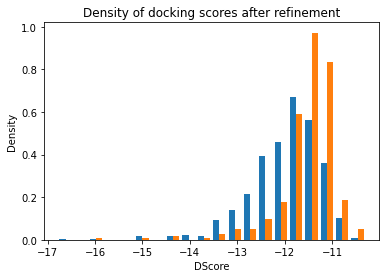

In [48]:
fig, ax = plt.subplots()
ax.hist([df_7nio.Score_7NIO, df_7nn0.Score_7NN0],
        density=True,
        label = ["7NIO", "7NN0"],
        bins = 20)
ax.set_title("Density of docking scores after refinement")
ax.set_ylabel("Density")
ax.set_xlabel("DScore")
fig.show()

How many molecules were predicted to be hits for both structures?<br>
Calculate size of the intersection

In [60]:
s1 = set(df_7nio["Molecule"])
s2 = set(df_7nn0["Molecule"])
len(list(s1.intersection(s2)))

314

So all molecules detected as hits for 7NN0, were also detected as hits for 7NIO

## Rank comparison shared hits

Create a common dataframe

In [211]:
df_7nn0.iloc[-1, :]

Molecule      CC(C)c1cnc(CN2CCCNC(=O)C2Cc2ccccc2)s1
Score_7NN0                                  -10.296
Rank_7NN0                                       314
Name: 313, dtype: object

In [17]:
df_intsec = pd.merge(df_7nio, df_7nn0, how="inner", on="Molecule")

In [62]:
df_intsec.head()

,Molecule,Score_7NIO,Rank_7NIO,Score_7NN0,Rank_7NN0
0,O=C1CCC(C(=O)N2CCOc3ccccc3C2)NC(=O)N1,-16.786,1,-15.953,1
1,Cc1n[nH]c(CN2CC3CCC[C@@H](C2)NC3=O)n1,-15.867,2,-14.855,2
2,O=C1N[C@H]2CCCC1CN(C(=O)NCCSCc1cccc(Cl)c1)C2,-15.026,3,-14.191,4
3,CN1CCCN(C(=O)N[C@H]2CCCOc3ccc(F)cc32)CC1,-14.954,4,-14.358,3
4,CC(C)CCOc1ccccc1CCNC(=O)N1CC2CCC[C@@H](C1)NC2=O,-14.926,5,-13.802,5


Compare ranks

Pearson correlation coefficient:  0.6349165969315969


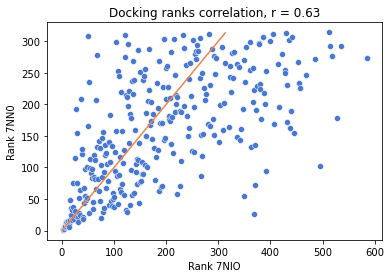

In [22]:
fig, ax = plt.subplots()
sns.scatterplot(data = df_intsec,
                x = 'Rank_7NIO',
                y = 'Rank_7NN0',
                ax=ax,
                color = cmap_d[0])
ax.plot(np.arange(1, df_7nn0.shape[0]), 
        np.arange(1, df_7nn0.shape[0]),
        color = cmap_d[1])
ax.set_xlabel('Rank 7NIO')
ax.set_ylabel('Rank 7NN0')
# Pearson correlation
corr_coef = df_intsec.corr(method='pearson',
                           numeric_only=True).loc['Rank_7NN0', 'Rank_7NIO']
print('Pearson correlation coefficient: ', corr_coef)
ax.set_title(f'Docking ranks correlation, r = {corr_coef:1.2f}')
fig.savefig('Ranks_correlation.png', dpi=600)

Compare scores

Pearson correlation coefficient:  0.8210063205240344


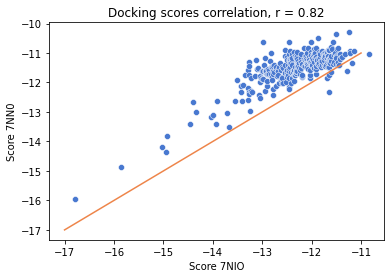

In [23]:
fig, ax = plt.subplots()
sns.scatterplot(data = df_intsec,
                x = 'Score_7NIO',
                y = 'Score_7NN0',
                ax=ax,
                color = cmap_d[0])
ax.plot(np.arange(-17, -10), 
        np.arange(-17, -10),
        color = cmap_d[1])
ax.set_xlabel('Score 7NIO')
ax.set_ylabel('Score 7NN0')
# Pearson correlation
corr_coef = df_intsec.corr(method='pearson',
                           numeric_only=True).loc['Score_7NN0', 'Score_7NIO']
print('Pearson correlation coefficient: ', corr_coef)
ax.set_title(f'Docking scores correlation, r = {corr_coef:1.2f}')
fig.savefig('Scores_correlation.png', dpi=600)

## Compare all hits (Tanimoto scores)

Why Tanimoto? https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0069-3 <br>
Complement of Tanimoto similarity is the Soergel distance (Soergel = 1 - Tanimoto)<br>
Tanimoto is the same as Jaccard coefficient: Intersection/Union<br>
To be able to use Tanimoto coef. you need molecular fingerprints (bit strings)<br>
Morgan fingerprint with radius 2 is roughly equivalent to ECFP4 and FCFP4.<br>
ECFP fragments encode atomic type, charge and mass

### Don't use additional features (as ECFP)

We want to create a similarity matrix of 7NIO vs 7NN0

In [59]:
# Initiate the similarity matrix
sim_mat = np.zeros((df_7nio.shape[0], df_7nn0.shape[0]))

for x in range(df_7nio.shape[0]):
    for y in range(df_7nn0.shape[0]):
        
        # Create the two molecule objects
        m_7nio = Chem.MolFromSmiles(df_7nio.Molecule.iloc[x])
        m_7nn0 = Chem.MolFromSmiles(df_7nn0.Molecule.iloc[y])
        
        # Generate the fingerprints
        fp_7nio = AllChem.GetMorganFingerprint(m_7nio, 2)
        fp_7nn0 = AllChem.GetMorganFingerprint(m_7nn0, 2)
        
        # Calculate Tanimoto coeff and record it in the matrix
        tani = DataStructs.TanimotoSimilarity(fp_7nio, fp_7nn0)
        sim_mat[x, y] = tani

Plot the distribution of the Tanimoto scores

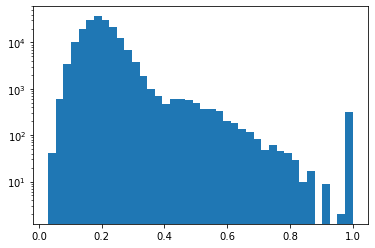

In [60]:
# Log!
x = plt.hist(sim_mat.flatten(), bins=40, log=True)

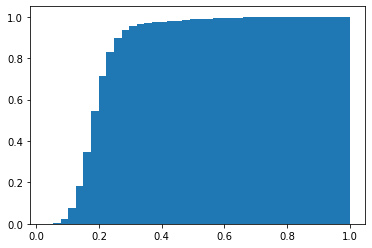

In [61]:
# Cumulative distribution
x = plt.hist(sim_mat.flatten(), bins=40, cumulative=True, density=True)

Show the distribution of the scores depending on the rank. For this use custom palette

In [62]:
plt_cmap = cm.get_cmap('rainbow', 256)
new_col = plt_cmap(np.linspace(0, 1, 256))
new_col[:51, :] = np.array([1, 1, 1, 1]) # White for values under 0.2 (ca 50%)
#new_col[-1, :] = np.array([1, 0, 0, 1]) # Red for value of 1.0
sim_palette = ListedColormap(new_col)

In [63]:
new_col.shape[0]*0.2

51.2

Text(0, 0.5, '7NN0 Rank')

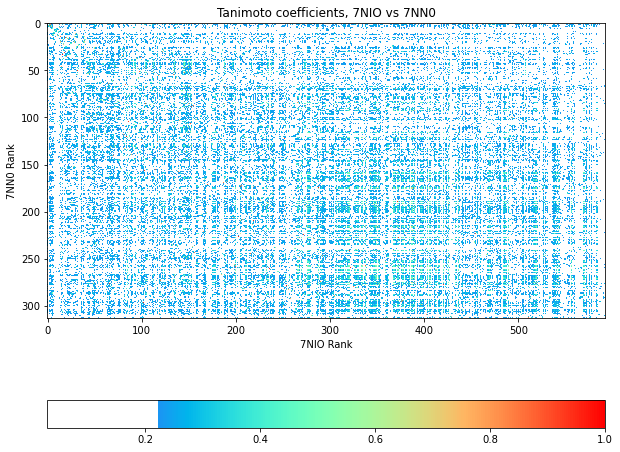

In [64]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.imshow(sim_mat.T, cmap=sim_palette)
plt.colorbar(orientation='horizontal')
plt.title('Tanimoto coefficients, 7NIO vs 7NN0')
plt.xlabel('7NIO Rank')
plt.ylabel('7NN0 Rank')

It is difficult to see anything on the big picture, but on smaller there is a tendency, at list for high ranks

Text(0, 0.5, '7NN0 Rank')

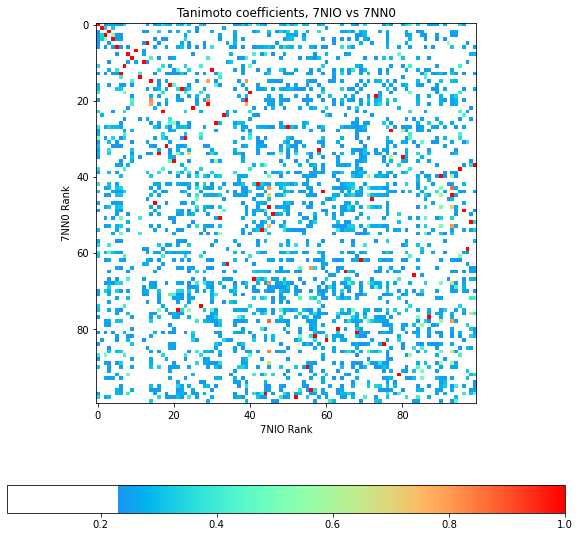

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.imshow(sim_mat.T[:100, :100], cmap=sim_palette)
plt.colorbar(orientation='horizontal')
plt.title('Tanimoto coefficients, 7NIO vs 7NN0')
plt.xlabel('7NIO Rank')
plt.ylabel('7NN0 Rank')

Text(0, 0.5, '7NN0 Rank')

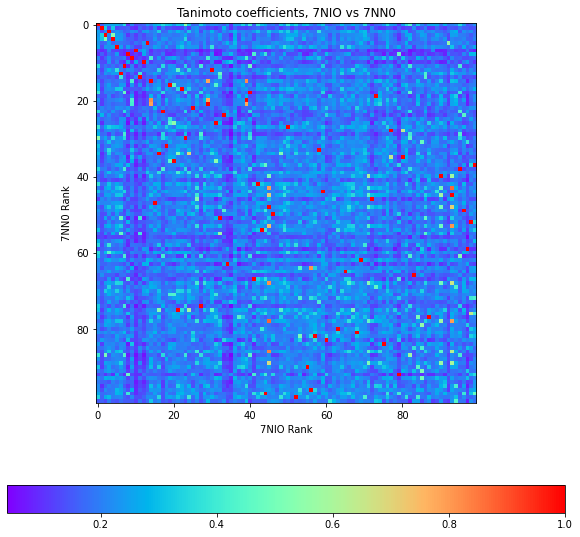

In [66]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.imshow(sim_mat.T[:100, :100], cmap='rainbow')
plt.colorbar(orientation='horizontal')
plt.title('Tanimoto coefficients, 7NIO vs 7NN0')
plt.xlabel('7NIO Rank')
plt.ylabel('7NN0 Rank')

Text(0, 0.5, '7NN0 Rank')

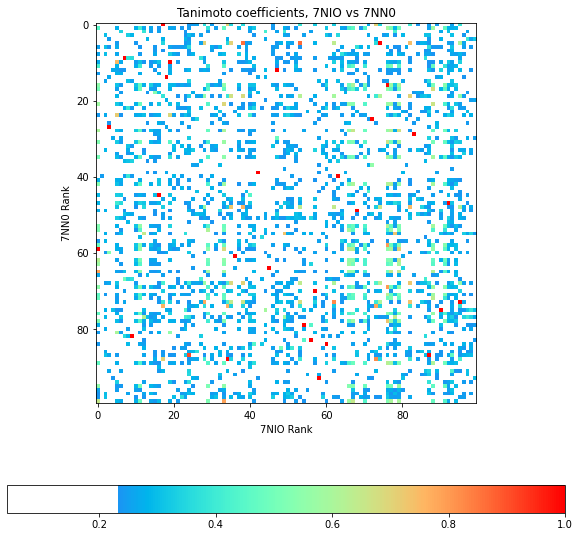

In [67]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.imshow(sim_mat.T[200:300, 200:300], cmap=sim_palette)
plt.colorbar(orientation='horizontal')
plt.title('Tanimoto coefficients, 7NIO vs 7NN0')
plt.xlabel('7NIO Rank')
plt.ylabel('7NN0 Rank')

### Use additional features (as FCFP)

We want to create a similarity matrix of 7NIO vs 7NN0

In [68]:
# Initiate the similarity matrix
fsim_mat = np.zeros((df_7nio.shape[0], df_7nn0.shape[0]))

for x in range(df_7nio.shape[0]):
    for y in range(df_7nn0.shape[0]):
        
        # Create the two molecule objects
        m_7nio = Chem.MolFromSmiles(df_7nio.Molecule.iloc[x])
        m_7nn0 = Chem.MolFromSmiles(df_7nn0.Molecule.iloc[y])
        
        # Generate the fingerprints
        fp_7nio = AllChem.GetMorganFingerprint(m_7nio, 2, useFeatures=True)
        fp_7nn0 = AllChem.GetMorganFingerprint(m_7nn0, 2, useFeatures=True)
        
        # Calculate Tanimoto coeff and record it in the matrix
        tani = DataStructs.TanimotoSimilarity(fp_7nio, fp_7nn0)
        fsim_mat[x, y] = tani

Plot the distribution of the Tanimoto scores

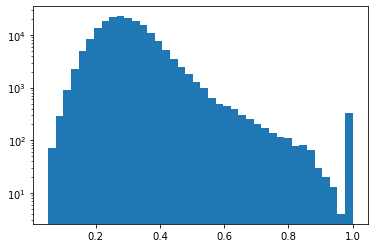

In [69]:
# Log!
x = plt.hist(fsim_mat.flatten(), bins=40, log=True)

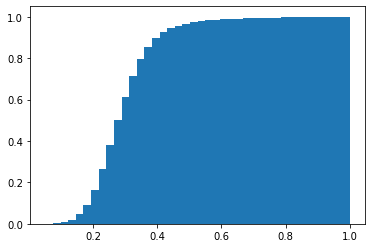

In [70]:
# Cumulative distribution
x = plt.hist(fsim_mat.flatten(), bins=40, cumulative=True, density=True)

Show the distribution of the scores depending on the rank. For this use custom palette

In [71]:
plt_cmap = cm.get_cmap('jet', 256)
new_col = plt_cmap(np.linspace(0, 1, 256))
new_col[:61, :] = np.array([1, 1, 1, 1]) # White for values under 0.2 (ca 50%)
#new_col[-1, :] = np.array([1, 0, 0, 1]) # Red for value of 1.0
fsim_palette = ListedColormap(new_col)

In [72]:
new_col.shape[0]*0.24

61.44

Text(0, 0.5, '7NN0 Rank')

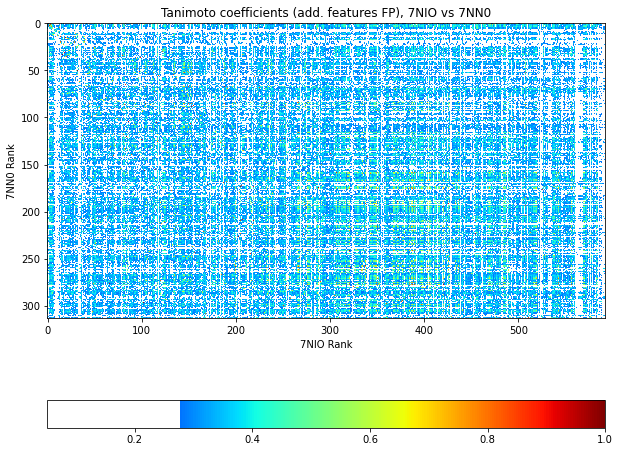

In [73]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.imshow(fsim_mat.T, cmap=fsim_palette)
plt.colorbar(orientation='horizontal')
plt.title('Tanimoto coefficients (add. features FP), 7NIO vs 7NN0')
plt.xlabel('7NIO Rank')
plt.ylabel('7NN0 Rank')

Text(0, 0.5, '7NN0 Rank')

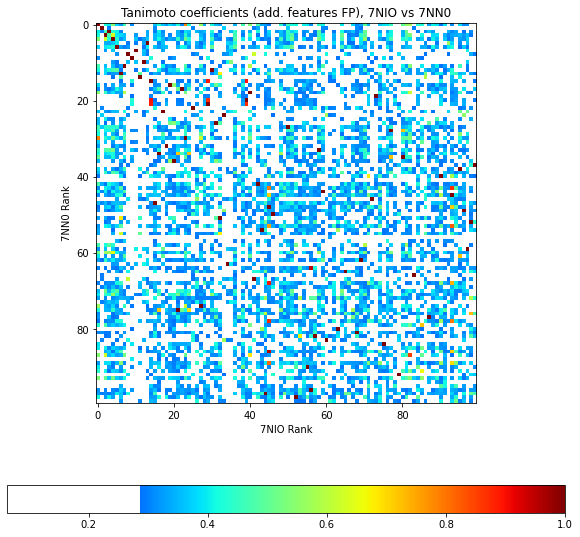

In [74]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.imshow(fsim_mat.T[:100, :100], cmap=fsim_palette)
plt.colorbar(orientation='horizontal')
plt.title('Tanimoto coefficients (add. features FP), 7NIO vs 7NN0')
plt.xlabel('7NIO Rank')
plt.ylabel('7NN0 Rank')

Text(0, 0.5, '7NN0 Rank')

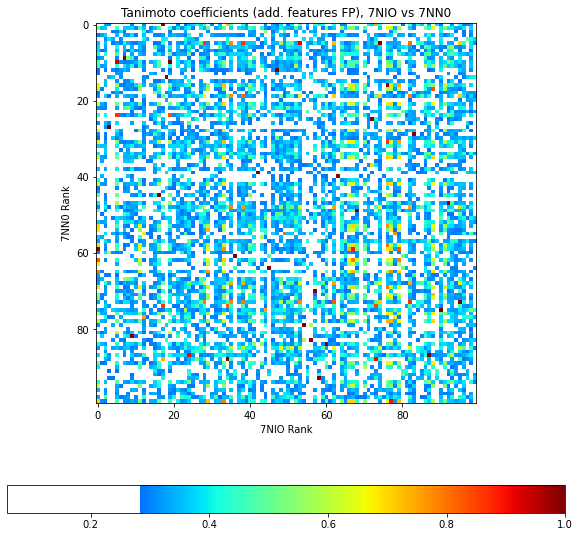

In [75]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.imshow(fsim_mat.T[200:300, 200:300], cmap=fsim_palette)
plt.colorbar(orientation='horizontal')
plt.title('Tanimoto coefficients (add. features FP), 7NIO vs 7NN0')
plt.xlabel('7NIO Rank')
plt.ylabel('7NN0 Rank')

## Tanimoto vs scores

Is there a relation between the docking scores and the Tanimoto coefficient?

In [24]:
# Initiate the list
tani_scores = []

for x in range(df_7nio.shape[0]):
    for y in range(df_7nn0.shape[0]):
        
        # Create the two molecule objects
        m_7nio = Chem.MolFromSmiles(df_7nio.Molecule.iloc[x])
        m_7nn0 = Chem.MolFromSmiles(df_7nn0.Molecule.iloc[y])
        
        # Generate the fingerprints
        fp_7nio = AllChem.GetMorganFingerprint(m_7nio, 2)
        fp_7nn0 = AllChem.GetMorganFingerprint(m_7nn0, 2)
        
        # Calculate Tanimoto coeff and record it in the matrix
        tani = DataStructs.TanimotoSimilarity(fp_7nio, fp_7nn0)
        tani_scores.append(pd.Series(data = [df_7nio['Score_7NIO'].iloc[x], df_7nn0['Score_7NN0'].iloc[y],tani],
                                     index=['Score_7NIO', 'Score_7NN0', 'Tanimoto_coefficient']))

In [26]:
tani_scores_df = pd.concat(tani_scores, axis=1).T

In [225]:
tani_scores_df

,Score_7NIO,Score_7NN0,Tanimoto_coefficient
0,-16.786,-15.953,1.000000
1,-16.786,-14.855,0.161616
2,-16.786,-14.358,0.252427
3,-16.786,-14.191,0.238532
4,-16.786,-13.802,0.254386
...,...,...,...
186197,-10.483,-10.619,0.157025
186198,-10.483,-10.615,0.146154
186199,-10.483,-10.478,0.261261
186200,-10.483,-10.344,0.098214


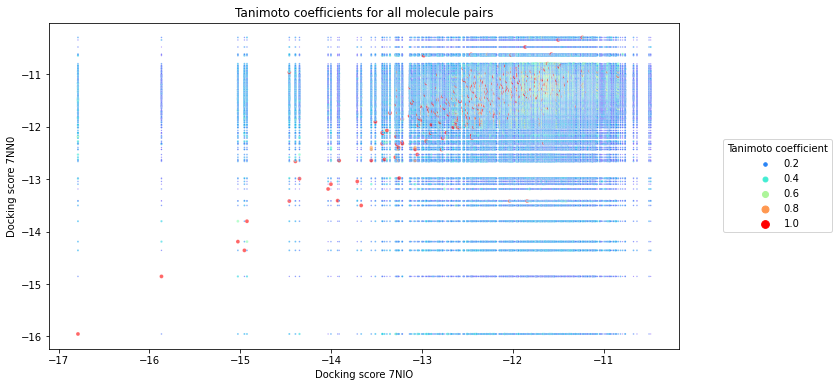

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.scatterplot(tani_scores_df, 
                x='Score_7NIO', 
                y='Score_7NN0', 
                hue='Tanimoto_coefficient',
                size = 'Tanimoto_coefficient',
                alpha = 0.6,
                s=2,
                marker = '.',
                sizes=(2, 60),
                palette = 'rainbow')
ax.legend(bbox_to_anchor=(1.25, 0.5), 
          loc='center right', 
          #borderaxespad=0,
          title='Tanimoto coefficient')
ax.set_xlabel('Docking score 7NIO')
ax.set_ylabel('Docking score 7NN0')
ax.set_title('Tanimoto coefficients for all molecule pairs')
fig.subplots_adjust(right=1.6)
fig.savefig('Tanimoto_all.png', dpi=600)

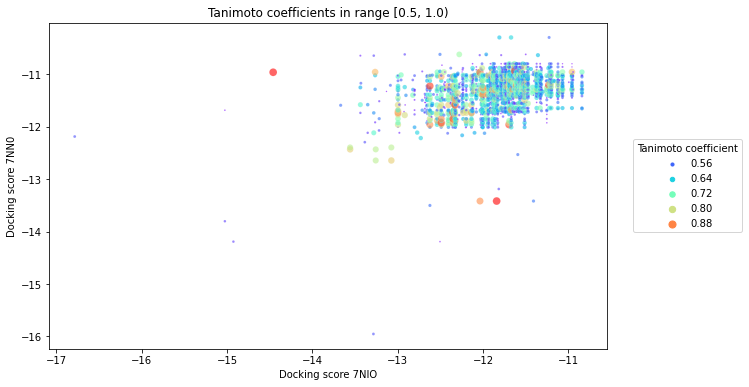

In [57]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.scatterplot(tani_scores_df[np.logical_and(tani_scores_df['Tanimoto_coefficient']>=0.5, tani_scores_df['Tanimoto_coefficient']<1)], 
                x='Score_7NIO', 
                y='Score_7NN0', 
                hue='Tanimoto_coefficient',
                size = 'Tanimoto_coefficient',
                alpha = 0.6,
                s=2,
                marker = 'o',
                sizes=(2, 60),
                palette = 'rainbow')
ax.legend(bbox_to_anchor=(1.25, 0.5), 
          loc='center right', 
          #borderaxespad=0,
          title='Tanimoto coefficient')
ax.set_xlabel('Docking score 7NIO')
ax.set_ylabel('Docking score 7NN0')
ax.set_title('Tanimoto coefficients in range [0.5, 1.0)')
fig.savefig('Tanimoto_range.png', dpi=600, bbox_inches="tight")

In [58]:
fig.subplots_adjust(right=1)
fig.savefig('Tanimoto_all.png', dpi=600, bbox_inches="tight")

## Are Tanimoto coef. higher for hits than for random?

For control load all molecules used for docking

In [80]:
all_mols = pd.read_csv('filtered_mols_90k.csv')['smiles']

In [77]:
all_mols.shape

(90497,)

We want to compare similarity of the first N=40 hits (first with first and so on) of 7nn0 and 7nio, and of 20 random molecules with the first 20 hits.

In [81]:
n=300
# Select n random molecules
rand_rows = np.random.randint(0, all_mols.shape[0]-1, n)
rand_mols = all_mols[rand_rows]

In [258]:
hit_sim = np.zeros(n)
rand_7nio = np.zeros(n)
rand_7nn0 = np.zeros(n)

for i in range(n):
    if df_7nio.Molecule.iloc[i] != df_7nn0.Molecule.iloc[i]:
        # Create the two molecule objects
        m_7nio = Chem.MolFromSmiles(df_7nio.Molecule.iloc[i])
        m_7nn0 = Chem.MolFromSmiles(df_7nn0.Molecule.iloc[i])
        rand_mol = Chem.MolFromSmiles(rand_mols.iloc[i])

        # Generate the fingerprints
        fp_7nio = AllChem.GetMorganFingerprint(m_7nio, 2)
        fp_7nn0 = AllChem.GetMorganFingerprint(m_7nn0, 2)
        fp_rand = AllChem.GetMorganFingerprint(rand_mol, 2)

        # Calculate Tanimoto coeff and record it in the matrix
        hit_sim[i] = DataStructs.TanimotoSimilarity(fp_7nio, fp_7nn0)
        rand_7nio[i] = DataStructs.TanimotoSimilarity(fp_7nio, fp_rand)
        rand_7nn0[i] = DataStructs.TanimotoSimilarity(fp_7nn0, fp_rand)

In [259]:
boxplot_df = pd.DataFrame({'7NIO_7NN0':hit_sim, '7NIO_random':rand_7nio, '7NN0_random':rand_7nn0})
boxplot_df = boxplot_df.melt(value_name='Tanimoto coefficient')
boxplot_df.head()

,variable,Tanimoto coefficient
0,7NIO_7NN0,0.000000
1,7NIO_7NN0,0.000000
2,7NIO_7NN0,0.210526
3,7NIO_7NN0,0.210526
4,7NIO_7NN0,0.000000


<AxesSubplot: xlabel='variable', ylabel='Tanimoto coefficient'>

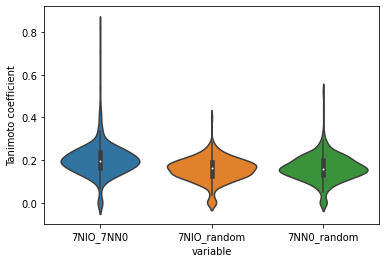

In [262]:
sns.violinplot(boxplot_df, x="variable", y='Tanimoto coefficient')

<AxesSubplot: xlabel='variable', ylabel='Tanimoto coefficient'>

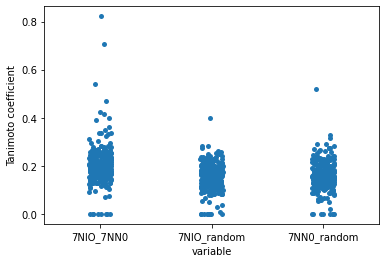

In [263]:
sns.stripplot(boxplot_df, x="variable", y='Tanimoto coefficient')

In [ ]:
df_7nn0.Molecule.iloc[i]

The same, but avereging over 5 nearest ranked molecules

In [102]:
av_7nn0_7nio = np.zeros(n)
av_7nio_7nn0 = np.zeros(n)
av_rand_7nio = np.zeros(n)
av_rand_7nn0 = np.zeros(n)

for i in range(3, n):
    # Create the reference molecule objects
    m_7nio = Chem.MolFromSmiles(df_7nio.Molecule.iloc[i])
    m_7nn0 = Chem.MolFromSmiles(df_7nn0.Molecule.iloc[i])
    rand_mol = Chem.MolFromSmiles(rand_mols.iloc[i])
    
    # Generate the fingerprints
    fp_7nio = AllChem.GetMorganFingerprint(m_7nio, 2)
    fp_7nn0 = AllChem.GetMorganFingerprint(m_7nn0, 2)
    fp_rand = AllChem.GetMorganFingerprint(rand_mol, 2)
    
    #Initialize tanimoto
    tan_7nio_7nn0 = 0
    tan_7nn0_7nio = 0
    tan_7nio_rand = 0
    tan_7nn0_rand = 0
    
    for j in range(-2, 3):
        # Generate the compared molecules
        m_7nio_c = Chem.MolFromSmiles(df_7nio.Molecule.iloc[j])
        m_7nn0_c = Chem.MolFromSmiles(df_7nn0.Molecule.iloc[j])
        rand_mol_c = Chem.MolFromSmiles(rand_mols.iloc[j])
        
        # Generate the fingerprints
        fp_7nio_c = AllChem.GetMorganFingerprint(m_7nio_c, 2)
        fp_7nn0_c = AllChem.GetMorganFingerprint(m_7nn0_c, 2)
        fp_rand_c = AllChem.GetMorganFingerprint(rand_mol_c, 2)

        # Calculate Tanimoto coeff and add them
        tan_7nio_7nn0 = DataStructs.TanimotoSimilarity(fp_7nio, fp_7nn0_c)
        tan_7nn0_7nio = DataStructs.TanimotoSimilarity(fp_7nio_c, fp_7nn0)
        tan_7nio_rand = DataStructs.TanimotoSimilarity(fp_7nio, fp_rand_c)
        tan_7nn0_rand = DataStructs.TanimotoSimilarity(fp_7nn0, fp_rand_c)
    
    av_7nn0_7nio[i] = tan_7nn0_7nio
    av_7nio_7nn0[i] = tan_7nio_7nn0
    av_rand_7nio[i] = tan_7nio_rand
    av_rand_7nn0[i] = tan_7nn0_rand

In [103]:
av_boxplot_df = pd.DataFrame({'7NIO_vs_av_7NN0':av_7nio_7nn0,
                              '7NN0_vs_av_7NIO':av_7nn0_7nio,
                              '7NIO_vs_av_random':av_rand_7nio, 
                              '7NN0_vs_av_random':av_rand_7nn0})
av_boxplot_df = av_boxplot_df.melt(value_name='Tanimoto coefficient')
av_boxplot_df.head(10)

,variable,Tanimoto coefficient
0,7NIO_vs_av_7NN0,0.000000
1,7NIO_vs_av_7NN0,0.000000
2,7NIO_vs_av_7NN0,0.000000
3,7NIO_vs_av_7NN0,1.000000
4,7NIO_vs_av_7NN0,0.196721
5,7NIO_vs_av_7NN0,0.230088
6,7NIO_vs_av_7NN0,0.206612
7,7NIO_vs_av_7NN0,0.159664
8,7NIO_vs_av_7NN0,0.171171
9,7NIO_vs_av_7NN0,0.224000


<AxesSubplot: xlabel='variable', ylabel='Tanimoto coefficient'>

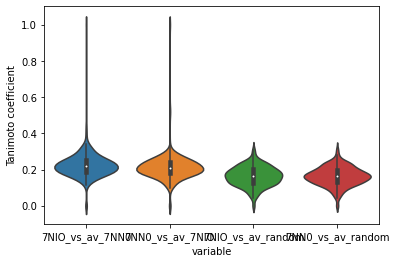

In [104]:
sns.violinplot(av_boxplot_df, x="variable", y='Tanimoto coefficient')

Tanimoto coeff distribution inside the groups

In [82]:
l_7nio = []
l_7nn0 = []
l_rand = []

for i in range(n):
    for j in range(n):
        if i<j:
            # Create the two molecule objects
            m_7nio1 = Chem.MolFromSmiles(df_7nio.Molecule.iloc[i])
            m_7nio2 = Chem.MolFromSmiles(df_7nio.Molecule.iloc[j])
            m_7nn01 = Chem.MolFromSmiles(df_7nn0.Molecule.iloc[i])
            m_7nn02 = Chem.MolFromSmiles(df_7nn0.Molecule.iloc[j])
            rand_mol1 = Chem.MolFromSmiles(rand_mols.iloc[i])
            rand_mol2 = Chem.MolFromSmiles(rand_mols.iloc[j])

            # Generate the fingerprints
            fp_7nio1 = AllChem.GetMorganFingerprint(m_7nio1, 2)
            fp_7nn01 = AllChem.GetMorganFingerprint(m_7nn01, 2)
            fp_rand1 = AllChem.GetMorganFingerprint(rand_mol1, 2)
            fp_7nio2 = AllChem.GetMorganFingerprint(m_7nio2, 2)
            fp_7nn02 = AllChem.GetMorganFingerprint(m_7nn02, 2)
            fp_rand2 = AllChem.GetMorganFingerprint(rand_mol2, 2)

            # Calculate Tanimoto coeff and record it in the matrix
            l_7nio.append(DataStructs.TanimotoSimilarity(fp_7nio1, fp_7nio2))
            l_7nn0.append(DataStructs.TanimotoSimilarity(fp_7nn01, fp_7nn02))
            l_rand.append(DataStructs.TanimotoSimilarity(fp_rand1, fp_rand2))

In [83]:
boxplot_df = pd.DataFrame({'7NIO':l_7nio, '7NN0':l_7nn0, 'Random':l_rand})
boxplot_df = boxplot_df.melt(value_name='Tanimoto coefficient')
boxplot_df.head()

,variable,Tanimoto coefficient
0,7NIO,0.161616
1,7NIO,0.238532
2,7NIO,0.252427
3,7NIO,0.254386
4,7NIO,0.259259


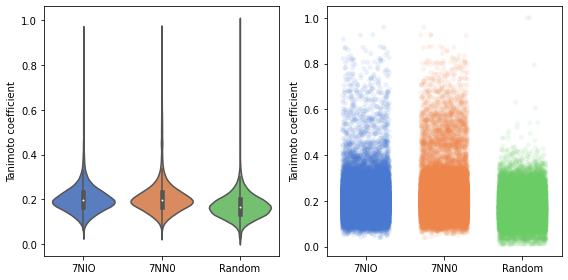

In [109]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(8, 4)
sns.violinplot(boxplot_df, x="variable", y='Tanimoto coefficient', ax=ax[0], palette='muted')
ax[0].set_xlabel(None)
sns.stripplot(boxplot_df, x="variable", y='Tanimoto coefficient', 
              hue='variable', ax=ax[1], palette='muted', alpha=0.1,
             jitter=0.3)
ax[1].legend().remove()
ax[1].set_xlabel(None)
plt.tight_layout()
fig.savefig('Tanimoto_hit_vs_random.png', dpi=600, bbox_inches="tight")

In [87]:
np.max(l_rand)

1.0

Is the difference significant?

First: Levene test to see if the variance is the same

In [69]:
stats.levene(l_7nio, l_rand)

LeveneResult(statistic=363.51609034760133, pvalue=6.988331422107382e-81)

In [70]:
stats.levene(l_7nn0, l_rand)

LeveneResult(statistic=816.3983223811924, pvalue=9.347215467461041e-179)

In [72]:
stats.levene(l_7nn0, l_7nio)

LeveneResult(statistic=111.93612569946485, pvalue=3.823496962840763e-26)

In [71]:
[np.var(x, ddof=1) for x in [l_7nio, l_7nn0, l_rand]]

[0.004776803818615043, 0.006423319693946032, 0.0026972257490074833]

Second: Welch t-test (since variance is significantly different)

In [79]:
stats.ttest_ind(np.array(l_7nio), np.array(l_rand), equal_var=False, alternative='greater')

Ttest_indResult(statistic=84.88000154267459, pvalue=0.0)

In [77]:
stats.ttest_ind(np.array(l_7nn0), np.array(l_rand), equal_var=False, alternative='greater')

Ttest_indResult(statistic=90.97057947578648, pvalue=0.0)

## Scatterplot Tanimoto > 0.9

In [41]:
filtered_mat = sim_mat.copy()
filtered_mat[sim_mat<0.9] = 0

In [42]:
sim_mat.shape

(593, 314)

In [43]:
filtered_ranks = np.where(filtered_mat!=0)
filtered_ranks = filtered_ranks + np.array([[1], [1]])

In [44]:
scat_df = pd.DataFrame(data={'7NIO_rank':filtered_ranks[0], 
                             '7NN0_rank':filtered_ranks[1], 
                             'Tanimoto': sim_mat[filtered_ranks[0]-1, filtered_ranks[1]-1]})
scat_df.head()

,7NIO_rank,7NN0_rank,Tanimoto
0,1,1,1.0
1,2,2,1.0
2,3,4,1.0
3,4,3,1.0
4,5,5,1.0


<AxesSubplot: title={'center': '7NIO vs 7NN0'}, xlabel='7NIO_rank', ylabel='7NN0_rank'>

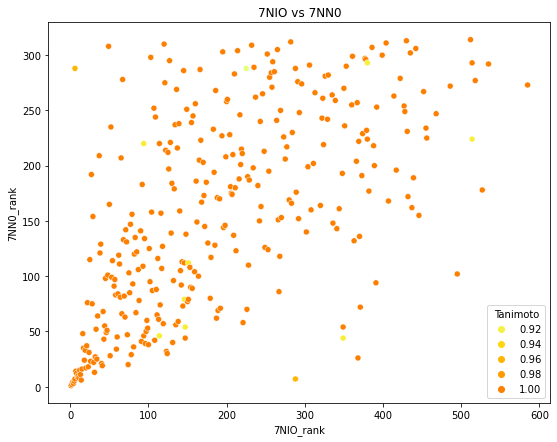

In [45]:
fig, ax = plt.subplots()
ax.set_title('7NIO vs 7NN0')
fig.set_size_inches(9, 7)
sns.scatterplot(data=scat_df,
               x='7NIO_rank',
               y='7NN0_rank',
               hue='Tanimoto',
               palette='Wistia',
               legend='brief',
               ax=ax)

## How do hits look like?

In [11]:
mols_7nio = []
mols_7nn0 = []
for i in range(5):
    mols_7nio.append(Chem.MolFromSmiles(df_7nio.Molecule.iloc[i]))
    mols_7nn0.append(Chem.MolFromSmiles(df_7nn0.Molecule.iloc[i]))
    

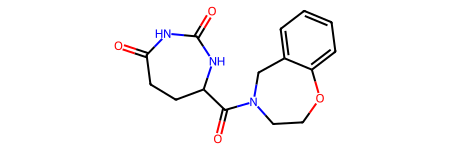

In [12]:
mols_7nio[0]

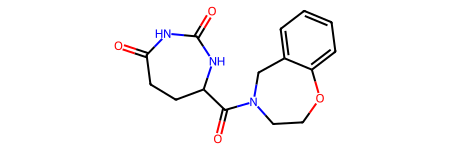

In [48]:
mols_7nn0[0]

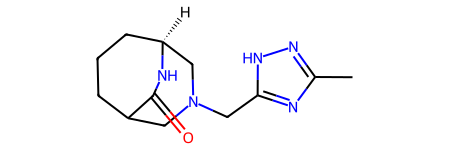

In [49]:
mols_7nio[1]

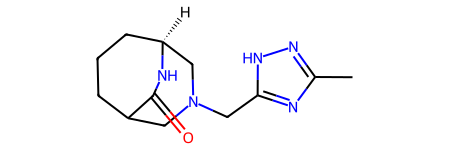

In [50]:
mols_7nn0[1]

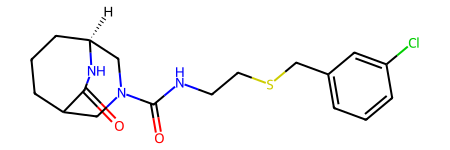

In [51]:
mols_7nio[2]

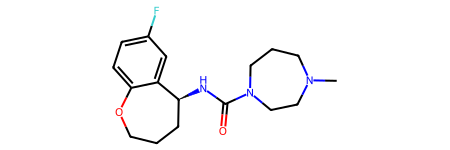

In [52]:
mols_7nn0[2]

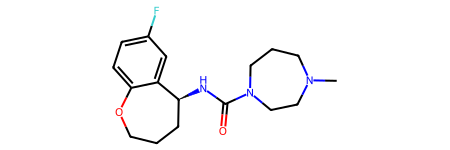

In [53]:
mols_7nio[3]

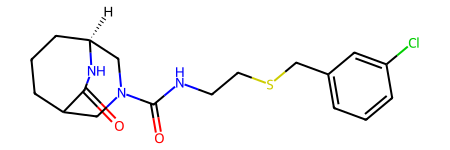

In [54]:
mols_7nn0[3]

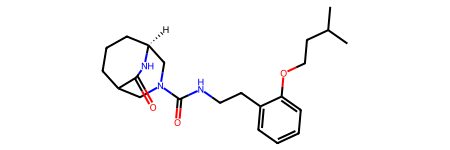

In [55]:
mols_7nio[4]

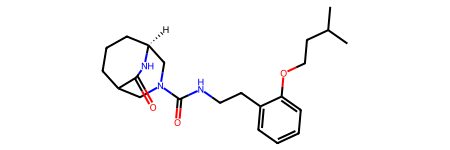

In [56]:
mols_7nn0[4]

In [15]:
# Save structures to file
for i in range(5):
    Draw.MolToFile(mols_7nio[i],f'ligand{i+1}.png')

## Similarities

It would be interesting to compare if some molecules in the first 100 have the same substructures. Molecules that have Tanimoto coeff. in (0.9, 1.0)

In [57]:
np.where(np.logical_and(sim_mat[:50, :50]>0.6, sim_mat[:50, :50]<1.0))

(array([14, 14, 24, 29, 29, 39, 39, 45, 45]),
 array([20, 21, 34, 15, 20, 15, 21, 43, 45]))

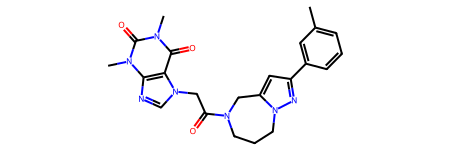

In [58]:
Chem.MolFromSmiles(df_7nio.Molecule.iloc[14])

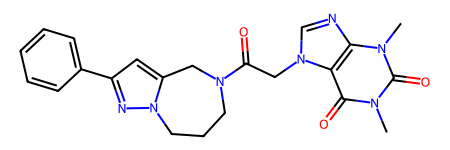

In [59]:
Chem.MolFromSmiles(df_7nn0.Molecule.iloc[20])

## Possible substructures

### 1

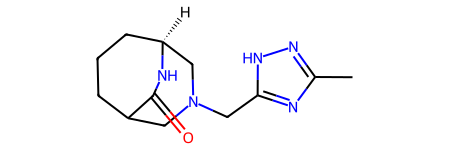

In [62]:
mols_7nio[1]

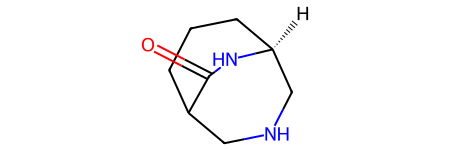

In [112]:
substr1 = Chem.MolFromSmiles('[C@@H]12CNCC(CCC1)C(N2)=O')
substr1

In [69]:
mols_7nio[0].HasSubstructMatch(substr1)

True

### 2

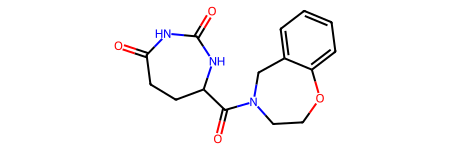

In [276]:
mols_7nio[0]

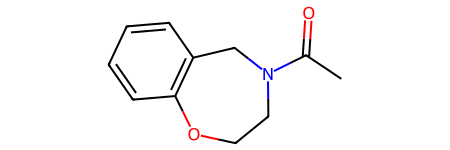

In [111]:
substr2 = Chem.MolFromSmiles('C1=CC=CC2=C1OCCN(C2)C(C)=O')
substr2

In [273]:
mols_7nio[3].HasSubstructMatch(substr1)

False

In [71]:
mols_7nio[0].HasSubstructMatch(substr_2)

False

In [113]:
Draw.MolToFile(substr1,f'substructure1.png')
Draw.MolToFile(substr2,f'substructure2.png')

### Look for substructures

We want to collect two dataframes: one for substructure 1 and one for substructure 2. Thez should have ranks and scores for both 7nio and 7nn0 (only molecules present in both are analyzed).

In [132]:
df_substr1 = []
df_substr2 = []
dfs = [df_substr1, df_substr2]
substructures = [substr1, substr2]
df_intsec['Substructure'] = 'None'
for s in range(len(dfs)):
    substr = substructures[s]
    for i in range(df_intsec.shape[0]):
        mol = Chem.MolFromSmiles(df_intsec.Molecule.iloc[i])
        if mol.HasSubstructMatch(substr):
            dfs[s].append(df_intsec.iloc[i, :])
            df_intsec['Substructure'].iloc[i] = str(s+1)

/tmp/ipykernel_1015286/2215636697.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_intsec['Substructure'].iloc[i] = str(s+1)


In [125]:
df_substr1 = pd.concat(df_substr1, axis=1).T
df_substr2 = pd.concat(df_substr2, axis=1).T

In [126]:
df_substr1.shape

(16, 5)

In [127]:
df_substr2.shape

(3, 5)

<AxesSubplot: xlabel='Score_7NIO', ylabel='Score_7NN0'>

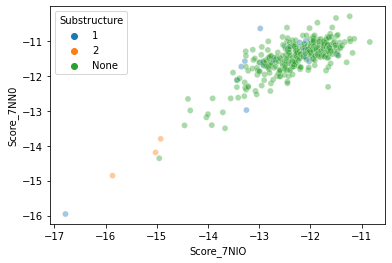

In [137]:
sns.scatterplot(df_intsec, x='Score_7NIO', y='Score_7NN0', hue='Substructure', alpha=0.4)

<AxesSubplot: xlabel='Rank_7NIO', ylabel='Rank_7NN0'>

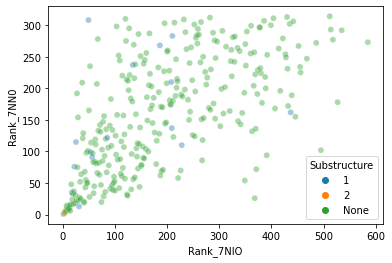

In [136]:
sns.scatterplot(df_intsec, x='Rank_7NIO', y='Rank_7NN0', hue='Substructure', alpha=0.4)

In [23]:
len(arr)

4294967295

In [23]:
len(arr)

4294967295

In [128]:
df_substr1.head()

,Molecule,Score_7NIO,Rank_7NIO,Score_7NN0,Rank_7NN0
0,O=C1CCC(C(=O)N2CCOc3ccccc3C2)NC(=O)N1,-16.786,1,-15.953,1
16,COc1ccc(C(=O)N2CCOc3ccc(C(=O)N4CCCC4)cc3C2)cc1F,-13.438,17,-12.115,35
21,C[C@H]1COc2ccc(C(=O)N3CCCC3)cc2CN1C(=O)c1ccccc1,-13.352,22,-11.735,76
24,O=C(c1ccc2c(c1)CN(C(=O)c1ccncc1)CCO2)N1CCCC1,-13.281,25,-11.578,115
30,COCCNC(=O)c1ccc2c(c1)CN(C(=O)CN1CCCCCC1)[C@@H]...,-13.251,31,-12.979,13


Now we want to look how many such subructures there are in all initial docking file

Are scores for molecules with the substructures generally higher? Look at initial screening results (ca 10k compounds), 7NIO

In [114]:
ori_df = pd.read_csv('7NIO_pocket1/7NIO_pocket1_docking_results_merged.csv')
ori_df['Substructure'] = 'None'
substructures = [substr1, substr2] 
for s in range(len(substructures)):
    substr = substructures[s]
    for i in range(ori_df.shape[0]):
        mol = Chem.MolFromSmiles(ori_df.smiles.iloc[i])
        if mol.HasSubstructMatch(substr):
            ori_df.Substructure.iloc[i] = str(s+1)

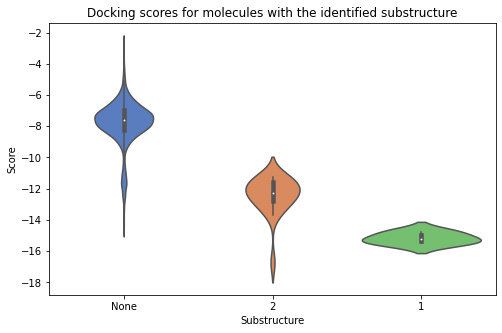

In [121]:
ori_df = ori_df[ori_df.Score != 'ERROR']
ori_df['Score'] = ori_df['Score'].astype('float')

fig, ax = plt.subplots()
fig.set_size_inches(8, 5)
sns.violinplot(ori_df, x='Substructure', y='Score', palette='muted', ax=ax)
ax.set_title('Docking scores for molecules with the identified substructure')
fig.savefig('Substructures.png', dpi=600)

In [165]:
ori_df[ori_df.Substructure=='1'].shape

(22, 3)

In [166]:
ori_df[ori_df.Substructure=='2'].shape

(3, 3)

Fazit: 
- mit Struktur 1, gab es 22 strukturen in gedockten dataset, 16 waren nach dem thresholding(unter -11)
- mit Struktur 2, gab es 3 strukturen in gedockten dataset, alle 3 waren nach dem thresholding(unter -11) und dann sogar in den top 5!

## Top five molecules -> Toxicity warning

In [122]:
ori_data = pd.read_csv('filtered_mols_90k.csv')

In [123]:
molecule_list = []
for hit in df_7nio.Molecule.iloc[:5]:
    warnings = ori_data[ori_data.smiles == hit].loc[:, ['smiles', 'warning_rules', 'warning_scores', 'warning_PAINS']]
    molecule_list.append(warnings)

In [124]:
pd.concat(molecule_list)

,smiles,warning_rules,warning_scores,warning_PAINS
52764,O=C1CCC(C(=O)N2CCOc3ccccc3C2)NC(=O)N1,None,NaN,None
52943,Cc1n[nH]c(CN2CC3CCC[C@@H](C2)NC3=O)n1,None,NaN,None
50399,O=C1N[C@H]2CCCC1CN(C(=O)NCCSCc1cccc(Cl)c1)C2,None,NaN,None
78394,CN1CCCN(C(=O)N[C@H]2CCCOc3ccc(F)cc32)CC1,None,NaN,None
56063,CC(C)CCOc1ccccc1CCNC(=O)N1CC2CCC[C@@H](C1)NC2=O,Pfizer,NaN,None


# Comparison with results of the Prague team

Firstly we want to have merged ranking: -> take average of the scores

In [125]:
df_intsec.head()

,Molecule,Score_7NIO,Rank_7NIO,Score_7NN0,Rank_7NN0
0,O=C1CCC(C(=O)N2CCOc3ccccc3C2)NC(=O)N1,-16.786,1,-15.953,1
1,Cc1n[nH]c(CN2CC3CCC[C@@H](C2)NC3=O)n1,-15.867,2,-14.855,2
2,O=C1N[C@H]2CCCC1CN(C(=O)NCCSCc1cccc(Cl)c1)C2,-15.026,3,-14.191,4
3,CN1CCCN(C(=O)N[C@H]2CCCOc3ccc(F)cc32)CC1,-14.954,4,-14.358,3
4,CC(C)CCOc1ccccc1CCNC(=O)N1CC2CCC[C@@H](C1)NC2=O,-14.926,5,-13.802,5


In [126]:
df_aver = df_intsec.copy()
df_aver['Mean_score'] = (df_aver.Score_7NIO + df_aver.Score_7NN0)/2
df_aver = df_aver.sort_values('Mean_score', axis=0).reset_index(drop=True)

In [127]:
df_aver.head()

,Molecule,Score_7NIO,Rank_7NIO,Score_7NN0,Rank_7NN0,Mean_score
0,O=C1CCC(C(=O)N2CCOc3ccccc3C2)NC(=O)N1,-16.786,1,-15.953,1,-16.3695
1,Cc1n[nH]c(CN2CC3CCC[C@@H](C2)NC3=O)n1,-15.867,2,-14.855,2,-15.3610
2,CN1CCCN(C(=O)N[C@H]2CCCOc3ccc(F)cc32)CC1,-14.954,4,-14.358,3,-14.6560
3,O=C1N[C@H]2CCCC1CN(C(=O)NCCSCc1cccc(Cl)c1)C2,-15.026,3,-14.191,4,-14.6085
4,CC(C)CCOc1ccccc1CCNC(=O)N1CC2CCC[C@@H](C1)NC2=O,-14.926,5,-13.802,5,-14.3640


In [128]:
df_aver['Mean_rank'] = np.arange(1, df_aver.shape[0]+1)

In [129]:
df_aver.head()

,Molecule,Score_7NIO,Rank_7NIO,Score_7NN0,Rank_7NN0,Mean_score,Mean_rank
0,O=C1CCC(C(=O)N2CCOc3ccccc3C2)NC(=O)N1,-16.786,1,-15.953,1,-16.3695,1
1,Cc1n[nH]c(CN2CC3CCC[C@@H](C2)NC3=O)n1,-15.867,2,-14.855,2,-15.3610,2
2,CN1CCCN(C(=O)N[C@H]2CCCOc3ccc(F)cc32)CC1,-14.954,4,-14.358,3,-14.6560,3
3,O=C1N[C@H]2CCCC1CN(C(=O)NCCSCc1cccc(Cl)c1)C2,-15.026,3,-14.191,4,-14.6085,4
4,CC(C)CCOc1ccccc1CCNC(=O)N1CC2CCC[C@@H](C1)NC2=O,-14.926,5,-13.802,5,-14.3640,5


Now we prepare the Prague data

In [130]:
prague = pd.read_csv('../Substances/prague_results.csv', header=None)
prague = prague.iloc[:, [0, 1, 3]]
prague.columns=['ID', 'Molecule', 'Score']

In [131]:
prague.head()

,ID,Molecule,Score
0,68003621,CCCCCCCC(CC)C(C1=CC=CC=C1)S(=O)(=O)N,-99.3640
1,135362805,CCCCCCCCC(C1=CC=CC=C1)S(=O)(=O)N,-94.9232
2,135348434,CC(CC=C)C(CC1=CC=CC=C1)S(=O)(=O)N,-89.4134
3,138668803,CC(CC=C)C(CCC1=CC=CC=C1)S(=O)(=O)N,-88.9502
4,153920407,CCCCCCC(C1=CC=CC=C1)S(=O)(=O)N,-88.2209


In [132]:
prague = prague.sort_values('Score', axis = 0).reset_index(drop=True)

In [133]:
prague['Rank'] = np.arange(1, prague.shape[0]+1)

In [134]:
prague.head()

,ID,Molecule,Score,Rank
0,ZINC000008575992,CCOC(=O)c1ccc(OCc2nn[nH]n2)cc1,-108.677,1
1,ZINC000004728194,COC(=O)c1ccc(OCc2nn[nH]n2)cc1,-102.841,2
2,ZINC000015938076,COc1ccc(CN=Nc2nn[nH]n2)cc1OC,-102.507,3
3,ZINC000004487993,COC(=O)c1cccc(OCc2nn[nH]n2)c1,-101.105,4
4,ZINC000016742028,O=C(Cc1nn[nH]n1)NCCc1ccccc1,-100.864,5


(array([ 1.,  0.,  0.,  0.,  0.,  2.,  2.,  0.,  2.,  3.,  5.,  6.,  7.,
        12., 12., 15., 16., 11.,  3.,  3.]),
 array([-108.677   , -107.555955, -106.43491 , -105.313865, -104.19282 ,
        -103.071775, -101.95073 , -100.829685,  -99.70864 ,  -98.587595,
         -97.46655 ,  -96.345505,  -95.22446 ,  -94.103415,  -92.98237 ,
         -91.861325,  -90.74028 ,  -89.619235,  -88.49819 ,  -87.377145,
         -86.2561  ]),
 <BarContainer object of 20 artists>)

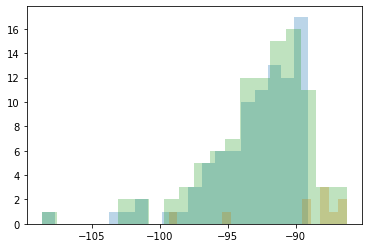

In [192]:
plt.hist(prague[prague.ID.str.startswith('ZINC')].Score, bins=20, alpha=0.3)
plt.hist(prague[~prague.ID.str.startswith('ZINC')].Score, bins=20, alpha=0.3)
plt.hist(prague.Score, bins=20, alpha=0.3)

In [193]:
prague['Database'] = ''
prague['Database'][prague.ID.str.startswith('Z')] = 'ZINC'
prague['Database'][~prague.ID.str.startswith('Z')] = 'PubChem'

/tmp/ipykernel_1023192/2216581959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prague['Database'][prague.ID.str.startswith('Z')] = 'ZINC'
/tmp/ipykernel_1023192/2216581959.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prague['Database'][~prague.ID.str.startswith('Z')] = 'PubChem'


In [194]:
prague

,ID,Molecule,Score,Rank,Database
0,ZINC000008575992,CCOC(=O)c1ccc(OCc2nn[nH]n2)cc1,-108.6770,1,ZINC
1,ZINC000004728194,COC(=O)c1ccc(OCc2nn[nH]n2)cc1,-102.8410,2,ZINC
2,ZINC000015938076,COc1ccc(CN=Nc2nn[nH]n2)cc1OC,-102.5070,3,ZINC
3,ZINC000004487993,COC(=O)c1cccc(OCc2nn[nH]n2)c1,-101.1050,4,ZINC
4,ZINC000016742028,O=C(Cc1nn[nH]n1)NCCc1ccccc1,-100.8640,5,ZINC
...,...,...,...,...,...
95,69259845,C1=CC=C(C=C1)C2C=CC=CC2S(=O)(=O)N,-88.0797,96,PubChem
96,135347813,CC1=CC=CC=C1C(CC=C)C(C)S(=O)(=O)N,-88.0119,97,PubChem
97,135347805,CC1=CC=CC=C1C(CC=C)C(C)S(=O)(=O)N,-87.1282,98,PubChem
98,135348432,CC(CC=C)C(CC1=CC=CC=C1)S(=O)(=O)N,-86.7149,99,PubChem


<AxesSubplot: xlabel='Score', ylabel='Count'>

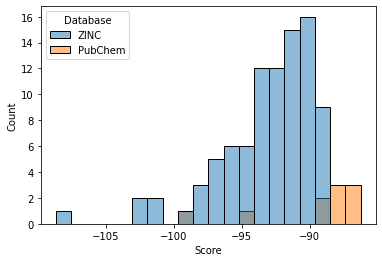

In [195]:
sns.histplot(prague, x='Score', hue='Database', bins=20)

## Similarity

Calculate Tanimoto similarity matrix

In [135]:
# Initiate the similarity matrix
sim_mat = np.zeros((df_aver.shape[0], prague.shape[0]))

for x in range(df_aver.shape[0]):
    for y in range(prague.shape[0]):
        
        # Create the two molecule objects
        m_our = Chem.MolFromSmiles(df_aver.Molecule.iloc[x])
        m_prag = Chem.MolFromSmiles(prague.Molecule.iloc[y])
        
        # Generate the fingerprints
        fp_our = AllChem.GetMorganFingerprint(m_our, 2)
        fp_prag = AllChem.GetMorganFingerprint(m_prag, 2)
        
        # Calculate Tanimoto coeff and record it in the matrix
        tani = DataStructs.TanimotoSimilarity(fp_our, fp_prag)
        sim_mat[x, y] = tani

Plot the distribution of the Tanimoto scores

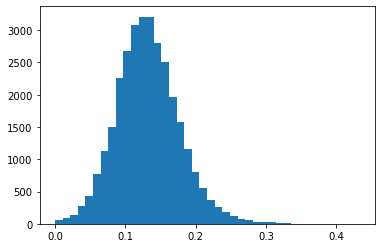

In [136]:
x = plt.hist(sim_mat.flatten(), bins=40)#, log=True)

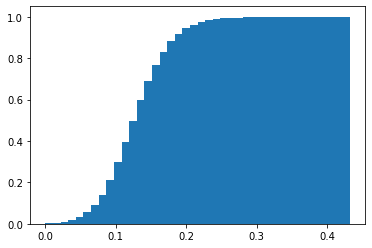

In [137]:
# Cumulative distribution
x = plt.hist(sim_mat.flatten(), bins=40, cumulative=True, density=True)

Show the distribution of the scores depending on the rank. For this use custom palette

In [138]:
plt_cmap = cm.get_cmap('rainbow', 256)
new_col = plt_cmap(np.linspace(0, 1, 256))
# new_col[:51, :] = np.array([1, 1, 1, 1]) # White for values under 0.2 (ca 50%)
# #new_col[-1, :] = np.array([1, 0, 0, 1]) # Red for value of 1.0
sim_palette = ListedColormap(new_col)

In [139]:
new_col.shape[0]*0.2

51.2

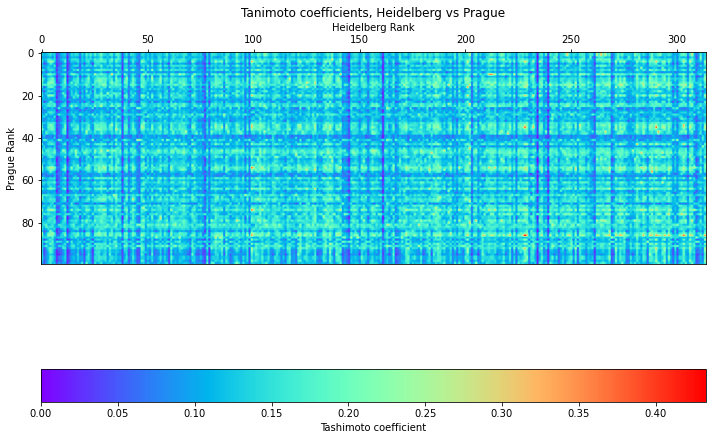

In [155]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.imshow(sim_mat.T, cmap=sim_palette)
plt.colorbar(orientation='horizontal', label='Tashimoto coefficient')
plt.title('Tanimoto coefficients, Heidelberg vs Prague')
plt.xlabel('Heidelberg Rank')
plt.ylabel('Prague Rank')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
plt.tight_layout()
fig.savefig('Tanimoto_prague.png', dpi=600, bbox_inches="tight")

Text(0, 0.5, 'Prague Rank')

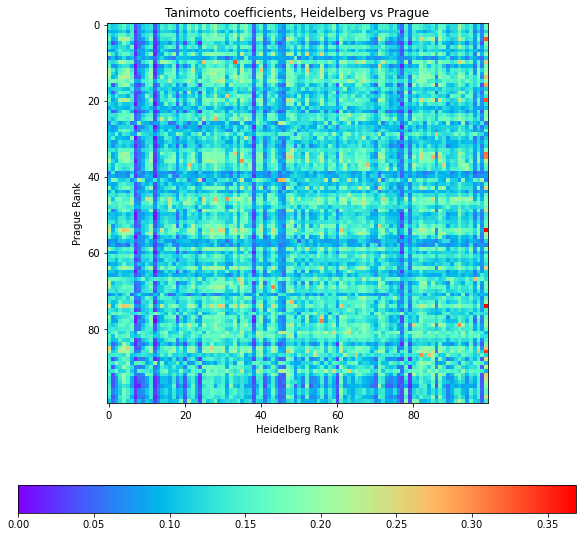

In [202]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
plt.imshow(sim_mat[:100, :100].T, cmap=sim_palette)
plt.colorbar(orientation='horizontal')
plt.title('Tanimoto coefficients, Heidelberg vs Prague')
plt.xlabel('Heidelberg Rank')
plt.ylabel('Prague Rank')

## Substructures

Are there molecules that contained the identified substructures in Prague dataset? How are distributions of scores for these molecules compared to the overall distribution of scores?

In [203]:
prague['Substructure'] = 'None'
substructures = [substr1, substr2]
for s in range(len(substructures)):
    substr = substructures[s]
    for i in range(prague.shape[0]):
        mol = Chem.MolFromSmiles(prague.Molecule.iloc[i])
        if mol.HasSubstructMatch(substr):
            prague.Substructure.iloc[i] = str(s+1)

In [204]:
prague.head()

,ID,Molecule,Score,Rank,Database,Substructure
0,ZINC000008575992,CCOC(=O)c1ccc(OCc2nn[nH]n2)cc1,-108.677,1,ZINC,None
1,ZINC000004728194,COC(=O)c1ccc(OCc2nn[nH]n2)cc1,-102.841,2,ZINC,None
2,ZINC000015938076,COc1ccc(CN=Nc2nn[nH]n2)cc1OC,-102.507,3,ZINC,None
3,ZINC000004487993,COC(=O)c1cccc(OCc2nn[nH]n2)c1,-101.105,4,ZINC,None
4,ZINC000016742028,O=C(Cc1nn[nH]n1)NCCc1ccccc1,-100.864,5,ZINC,None


<AxesSubplot: xlabel='Substructure', ylabel='Score'>

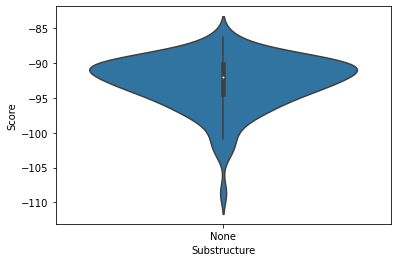

In [205]:
sns.violinplot(prague, x='Substructure', y='Score')

# Pocket comparison

Residue overlap?

In [161]:
pstr_7nio = '120+123+124+135+138+139+142+143+146+179+180+181+228+230+231+232+233+283+284+285+287+288+289+290+309+310+311+312+313+316+320+360+361+374+375+378+380+381+382+383+386+404+407+408+409+410+422+442+443+537+538+539+540'
p_7nio = set(pstr_7nio.split('+'))
pstr_7nn0 = '284+285+284+285+285+287+288+289+375+404+442+443+538+540+567+285+287+288+375+404+443+538+567+285+287+288+289+443+538+540+567+286+287+288+289+290+312+313+316+320+374+375+404+442+443+537+538+540+567'
p_7nn0 = set(pstr_7nn0.split('+'))

In [163]:
intersec = len(p_7nio.intersection(p_7nn0))

In [164]:
# Fraction overlap 7NIO
intersec/len(p_7nio)

0.33962264150943394

In [165]:
# Fraction overlap 7NN0
intersec/len(p_7nn0)

0.9

In [186]:
#IoU
intersec/(len(p_7nn0) + len(p_7nio) - intersec)

0.32727272727272727

Docking box overlap?

In [167]:
center_7nio = [-25.229235, 25.126171, -28.270075]
size_7nio = 30
center_7nn0 = [-18.814,  35.191, -19.548]
size_7nn0 = 25

In [179]:
x = abs(center_7nio[0] + 15 - (center_7nn0[0] - 12.5))
y = abs(center_7nio[1] + 15 - (center_7nn0[1] - 12.5))
z = abs(center_7nio[2] + 15 - (center_7nn0[2] - 12.5))
volume_intersection = x*y*z

In [184]:
volume_intersection / 30**3

0.25566943524460517

In [183]:
volume_intersection /25**3

0.44179678410267775

In [185]:
# IoU
volume_intersection/(25**3 +30**3 - volume_intersection)

0.1932447566474422